# Libraries

In [0]:
!pip install pytorch-transformers

In [0]:
!pip install tensorboardX

In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook, tnrange

from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import re

import pandas as pd

import torch
from pytorch_transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig, XLNetPreTrainedModel, XLNetModel, AdamW, WarmupLinearSchedule

logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/Guided Research/"

# Utility Functions

In [0]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""BERT finetuning runner."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_val_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the validation set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()
        
    @classmethod
    def _read_csv(cls, input_path, input_file, quotechar=None):
        df = pd.read_pickle(input_path + input_file)
        sentences = df['Sentence'].tolist()
        triplets = df['Triplet'].tolist()
        centities = df['Coarse_Entity'].tolist()
        fentities = df['Fine_Entity'].tolist()
        return [sentences,triplets,centities,fentities]

class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train/"), "dataframePerceptionUncertainty"), "train")
        
    def get_val_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "validation/"), "dataframePerceptionUncertainty"), "val")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test/"), "dataframePerceptionUncertainty"), "test")

    def get_labels(self):
        """See base class."""
        ABSA = []
        entities_fine = ['organic general', 'organic products', 'organic farmers', 'organic companies', 'conventional general', 'conventional products', 
                         'conventional farming', 'conventional companies', 'GMOs genetic engineering general']
        #attributes = ['g', 'p', 'll', 'h', 'e', 'c', 's', 'q', 'pp', 't', 'or', 'a', 'l', 'av']
        #sentiments = ['0','p','n']
        entities = ['organic', 'conventional', 'GMO']
        attributes = ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment']
        sentiments = ['0','p','n']
        for entity in entities:
            for attribute in attributes:
                for sentiment in sentiments:
                    ABSA.append(entity+'-'+attribute+'-'+sentiment)
        return [ABSA, entities, entities_fine]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i in range(len(lines[0])):
            guid = "%s-%s" % (set_type, i)
            text_a = lines[0][i]
            label = (lines[1][i],lines[2][i],lines[3][i])
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
                                 cls_token_at_end=False,
                                 cls_token='[CLS]',
                                 cls_token_segment_id=1,
                                 sep_token='[SEP]',
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0, 
                                 sequence_b_segment_id=1,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    mlb = []
    for i in range(3):
        mlb.append(MultiLabelBinarizer())
        mlb[i].fit_transform([label_list[i]])

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 1000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3". " -4" for RoBERTa.
            special_tokens_count = 3
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - special_tokens_count)
        else:
            # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
            special_tokens_count = 2
            if len(tokens_a) > max_seq_length - special_tokens_count:
                tokens_a = tokens_a[:(max_seq_length - special_tokens_count)]

        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        heads = ['ABSA', 'Entity', 'Entity_Fine']
        label_id = {heads[i]: mlb[i].transform([example.label[i]])[0] for i in range(3)}

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label-{0}: {1}".format(heads[0], " ".join([str(x) for x in label_id[heads[0]]])))
            logger.info("label-{0}: {1}".format(heads[1], " ".join([str(x) for x in label_id[heads[1]]])))
            logger.info("label-{0}: {1}".format(heads[2], " ".join([str(x) for x in label_id[heads[2]]])))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features, {heads[i]: mlb[i].classes_ for i in range(3)}


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels, average='binary'):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average=average)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }

def compute_metrics(preds, labels):
    assert len(preds) == len(labels)
    return {"acc": acc_and_f1(preds, labels, 'micro')}

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def plot_train_val_trace(train_trace, validation_trace):
    train_val_ratio = int(len(train_trace)/len(validation_trace))
    train_loss = []
    for i in range(len(validation_trace)):
        train_loss.append(np.mean(train_trace[i*train_val_ratio:(i+1)*train_val_ratio]))
    plt.plot(running_mean(train_loss,15),label='Training Loss')
    plt.plot(running_mean(validation_trace,15),label='Validation Loss')
    plt.legend()
    plt.show()

def plot_multiple_count(dataset):
    dataloader = DataLoader(dataset, batch_size=len(dataset))
    for batch in dataloader:
        ABSA = torch.sum(batch[3], (1), dtype=torch.int)
        unique, counts = np.unique(ABSA.numpy(), return_counts=True)
        
        plt.figure(figsize=(10,6))
        ax = sns.barplot(unique, counts)
        
        plt.title("Comments having multiple ABSA labels", {'fontsize': 18})
        plt.ylabel('Number of comments', fontsize=18)
        plt.xlabel('Number of labels', fontsize=18)

        #adding the text labels
        rects = ax.patches
        labels = counts
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')



In [0]:
def load_and_cache_examples(args, tokenizer, datasetType='train'):
    processor = Sst2Processor()
    output_mode = "classification"
    # Load data features from cache or dataset file

    logger.info("Creating features from dataset file at %s", args.data_dir)
    label_list = processor.get_labels()

    examples = processor.get_train_examples(args.data_dir) if datasetType=='train' else (processor.get_val_examples(args.data_dir) if datasetType=='val' else processor.get_test_examples(args.data_dir))
    features, head_classes = convert_examples_to_features(examples, label_list, args.max_seq_length, tokenizer, output_mode,
                                                            cls_token_at_end=True,            # xlnet has a cls token at the end
                                                            cls_token=tokenizer.cls_token,
                                                            cls_token_segment_id=2,
                                                            sep_token=tokenizer.sep_token,
                                                            pad_on_left=True,                 # pad on the left for xlnet
                                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                            pad_token_segment_id=4,
                                                        )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids_absa = torch.tensor([f.label_id['ABSA'] for f in features], dtype=torch.float)
    all_label_ids_centity = torch.tensor([f.label_id['Entity'] for f in features], dtype=torch.float)
    all_label_ids_fentity = torch.tensor([f.label_id['Entity_Fine'] for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids_absa, all_label_ids_centity, all_label_ids_fentity)
    if datasetType == 'train':
        return dataset, head_classes
    return dataset


In [0]:
def binary_focal_loss(y_pred , y_true, gamma=2.0, alpha=0.25, reduction="mean", function=torch.sigmoid, **kwargs):
    """
    Binary Version of Focal Loss
    :args
    
    y_pred : prediction
    
    y_true : true target labels
    
    gamma: damping factor default value 2 works well according to reasearch paper
    
    alpha : postive to negative ratio default value 0.25: means 1 positive and 3 negative. can be tuple ,list ,int and float
    
    reduction = mean,sum,none

    function = can be sigmoid or softmax or None
    
    **kwargs: parameters to pass in activation function like dim in softmax
    
    """
    if isinstance(alpha,(list,tuple)):
        pos_alpha = alpha[0] # postive sample ratio in the entire dataset
        neg_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        pos_alpha = alpha
        neg_alpha = (1-alpha)
        
    # if else in function can be simplified be removing setting to default to sigmoid  for educational purpose
    if function is not None:
        y_pred = function(y_pred , **kwargs) #apply activation function
    else :
        assert ((y_pred <= 1) & (y_pred >= 0)).all().item() , "negative value in y_pred value should be in the range of 0 to 1 inclusive"
    
    pos_pt = torch.where(y_true==1 , y_pred , torch.ones_like(y_pred)) # positive pt (fill all the 0 place in y_true with 1 so (1-pt)=0 and log(pt)=0.0) where pt is 1
    neg_pt = torch.where(y_true==0 , y_pred , torch.zeros_like(y_pred)) # negative pt
    
    pos_modulating = (1-pos_pt)**gamma # compute postive modulating factor for correct classification the value approaches to zero
    neg_modulating = (neg_pt)**gamma # compute negative modulating factor
    
    
    pos = -pos_alpha* pos_modulating*torch.log(pos_pt) #pos part
    neg = -neg_alpha* neg_modulating*torch.log(1-neg_pt) # neg part
    
    loss = pos+neg  # this is final loss to be returned with some reduction
    
    # apply reduction
    if reduction =="mean":
        return loss.mean()
    elif reduction =="sum":
        return loss.sum()
    elif reduction =="none":
        return loss # reduction mean
    else:
        raise f"Wrong reduction {reduction} is choosen \n choose one among [mean,sum,none]  "
    

# Model

In [0]:
class XLNetABSA(XLNetPreTrainedModel):
    def __init__(self, config):
        super(XLNetABSA, self).__init__(config)
        self.num_labels = config.num_labels

        self.transformer = XLNetModel(config)
        self.sequence_summary = SequenceSummary(config)
        self.logits_proj = nn.Linear(config.d_model, config.num_labels)

        self.apply(self.init_weights)

    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None,
                mems=None, perm_mask=None, target_mapping=None,
                labels=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]

        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        outputs = (logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # return (loss), logits, mems, (hidden states), (attentions)


In [0]:
class XLNetABSAwithHeads(torch.nn.Module):
    def __init__(self, config, xlnetDim = 768, model_type='xlnet-base-cased', dropout=0.1):
        super(XLNetABSAwithHeads, self).__init__()

        self.transformer = XLNetModel.from_pretrained(model_type)
        #self.dropout_layer = torch.nn.Dropout(dropout)

        self.configHead = config
        config_dict = {}
        for head in self.configHead:
            config_dict[head] = torch.nn.Linear(in_features=xlnetDim, out_features=self.configHead[head])
        self.heads = torch.nn.ModuleDict(config_dict)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, torch.nn.ModuleDict):
            # Initialize each linear layer
            for layer in module.children():
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if isinstance(layer, torch.nn.Linear) and layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None, mems=None, perm_mask=None, target_mapping=None, labels=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]
        # Pick the last token for classification
        output = output[:, -1]
        # Do dropout
        #output = self.dropout_layer(output)

        head_logits = {}
        for head in self.configHead:
            head_logits[head] = self.heads[head](output)

        outputs = (head_logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        if labels is not None:
            head_loss = {}
            loss_fct = BCEWithLogitsLoss()
            for head in self.configHead:
                # head_loss[head] = loss_fct(head_logits[head], labels[head])
                head_loss[head] = binary_focal_loss(head_logits[head], labels[head], gamma=3, alpha=[50,1])
            outputs = (sum(head_loss.values()), head_loss) + outputs

        return outputs  # return (loss), logits, mems, (hidden states), (attentions)


# Main

In [0]:
def readConfig():
    args = argparse.Namespace()
    args.model_type = 'xlnet-base-cased'
    args.data_dir = sharedGFolderPath+'data/'
    args.output_dir = sharedGFolderPath+'output/Current/'
    args.max_seq_length = 32
    args.train_batch_size = 32
    args.eval_batch_size = 32
    args.learning_rate = 5e-5
    args.num_train_epochs = 3.0
    args.warmup_steps = 0
    args.seed = 42
    args.weight_decay = 0.1
    args.adam_epsilon = 1e-8
    args.max_grad_norm = 1.0
    args.logging_steps = 50
    args.save_steps = 0
    args.evaluate_during_training = True
    
    return args

In [0]:
args = readConfig()
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)

In [0]:
headConfig = {'ABSA' : 54, 'Entity' : 3, 'Entity_Fine' : 9}
#headConfig = {'ABSA' : 54}
tokenizer = XLNetTokenizer.from_pretrained(args.model_type)

10/12/2019 21:14:25 - INFO - pytorch_transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model not found in cache or force_download set to True, downloading to /tmp/tmpj_prpsdo
100%|██████████| 798011/798011 [00:00<00:00, 1653374.24B/s]
10/12/2019 21:14:26 - INFO - pytorch_transformers.file_utils -   copying /tmp/tmpj_prpsdo to cache at /root/.cache/torch/pytorch_transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
10/12/2019 21:14:26 - INFO - pytorch_transformers.file_utils -   creating metadata file for /root/.cache/torch/pytorch_transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
10/12/2019 21:14:26 - INFO - pytorch_transformers.file_utils -   removing temp file /tmp/tmpj_prpsdo
10/12/2019 21:14:26 - INFO - pytorch_transformers.tokenization_utils -   loa

In [0]:
model = XLNetABSAwithHeads(headConfig, model_type=args.model_type)

In [0]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

## Training / Evaluation

In [0]:
def train(args, train_dataset, model, tokenizer, eval_dataset):
    """ Train the model """
    loss_trace = []
    eval_loss_trace = []
    head_loss_trace = {head: [] for head in headConfig}

    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss = 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         {'ABSA' : batch[3], 'Entity' : batch[4], 'Entity_Fine' : batch[5]}}
            outputs = model(**inputs)
            loss, detailed_loss = outputs[:2]  # model outputs are always tuple in pytorch-transformers (see doc)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            loss_trace.append(loss.item())
            for head in headConfig:
                head_loss_trace[head].append(detailed_loss[head].item())
            epoch_iterator.set_postfix(loss=loss.item())
            tr_loss += loss.item()
            scheduler.step()  # Update learning rate schedule
            optimizer.step()
            model.zero_grad()
            global_step += 1

            if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                # Log metrics
                if args.evaluate_during_training:  # Only evaluate when single GPU otherwise metrics may not average well
                    eval_loss_trace.extend(evaluate(args, model, tokenizer, eval_dataset, prefix=str(global_step))[1])


            if args.save_steps > 0 and global_step % args.save_steps == 0:
                # Save model checkpoint
                if not os.path.exists(args.output_dir):
                    os.makedirs(args.output_dir)
                logger.info("Saving model checkpoint to %s", args.output_dir)
                torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))
                torch.save(model.state_dict(), os.path.join(args.output_dir, 'checkpoint-{}.pt'.format(global_step)))

    return global_step, tr_loss / global_step, loss_trace, head_loss_trace, eval_loss_trace

In [0]:
def evaluate(args, model, tokenizer, eval_dataset, prefix=""):
    loss_trace = []

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    sig = torch.nn.Sigmoid()
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         {'ABSA' : batch[3], 'Entity' : batch[4], 'Entity_Fine' : batch[5]}}
            outputs = model(**inputs)
            loss, detailed_loss, logits = outputs[:3]

            loss_trace.append(loss.item())
            eval_loss += loss.item()
        nb_eval_steps += 1
        if preds is None:
            preds = {head: sig(logits[head]).detach().cpu().numpy() for head in headConfig}
            out_label_ids = {head: inputs['labels'][head].detach().cpu().numpy() for head in headConfig}
        else:
            preds = {head: np.append(preds[head], sig(logits[head]).detach().cpu().numpy(), axis=0) for head in headConfig}
            out_label_ids = {head: np.append(out_label_ids[head], inputs['labels'][head].detach().cpu().numpy(), axis=0) for head in headConfig}

    eval_loss = eval_loss / nb_eval_steps
    logger.info("evaluation average loss = %s", eval_loss)
    results = {head: {'actual': out_label_ids[head], 'preds': preds[head]} for head in headConfig}

    return eval_loss, loss_trace, results

In [0]:
if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))

set_seed(args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

train_dataset, head_classes = load_and_cache_examples(args, tokenizer, datasetType='train')
eval_dataset = load_and_cache_examples(args, tokenizer, 'eval')

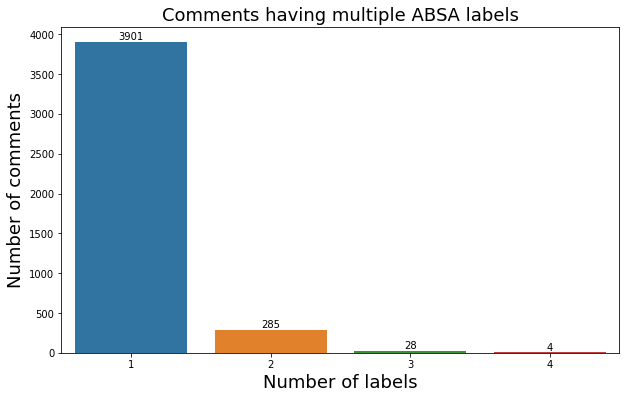

In [0]:
plot_multiple_count(train_dataset)

In [0]:
model.to(device)

global_step, tr_loss, train_loss_trace, train_head_loss_trace, eval_loss_trace = train(args, train_dataset, model, tokenizer, eval_dataset)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

10/12/2019 21:16:48 - INFO - __main__ -   ***** Running training *****
10/12/2019 21:16:48 - INFO - __main__ -     Num examples = 4218
10/12/2019 21:16:48 - INFO - __main__ -     Num Epochs = 3
10/12/2019 21:16:48 - INFO - __main__ -     Total optimization steps = 396


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
10/12/2019 21:17:14 - INFO - __main__ -   ***** Running evaluation 50 *****
10/12/2019 21:17:14 - INFO - __main__ -     Num examples = 433
10/12/2019 21:17:14 - INFO - __main__ -     Batch size = 32


10/12/2019 21:17:16 - INFO - __main__ -   evaluation average loss = 0.5675186706440789
10/12/2019 21:17:42 - INFO - __main__ -   ***** Running evaluation 100 *****
10/12/2019 21:17:42 - INFO - __main__ -     Num examples = 433
10/12/2019 21:17:42 - INFO - __main__ -     Batch size = 32


10/12/2019 21:17:44 - INFO - __main__ -   evaluation average loss = 0.501380096588816


10/12/2019 21:18:09 - INFO - __main__ -   ***** Running evaluation 150 *****
10/12/2019 21:18:09 - INFO - __main__ -     Num examples = 433
10/12/2019 21:18:09 - INFO - __main__ -     Batch size = 32


10/12/2019 21:18:11 - INFO - __main__ -   evaluation average loss = 0.46726477571896147
10/12/2019 21:18:37 - INFO - __main__ -   ***** Running evaluation 200 *****
10/12/2019 21:18:37 - INFO - __main__ -     Num examples = 433
10/12/2019 21:18:37 - INFO - __main__ -     Batch size = 32


10/12/2019 21:18:39 - INFO - __main__ -   evaluation average loss = 0.4596341060740607
10/12/2019 21:19:05 - INFO - __main__ -   ***** Running evaluation 250 *****
10/12/2019 21:19:05 - INFO - __main__ -     Num examples = 433
10/12/2019 21:19:05 - INFO - __main__ -     Batch size = 32


10/12/2019 21:19:07 - INFO - __main__ -   evaluation average loss = 0.4303340528692518


10/12/2019 21:19:33 - INFO - __main__ -   ***** Running evaluation 300 *****
10/12/2019 21:19:33 - INFO - __main__ -     Num examples = 433
10/12/2019 21:19:33 - INFO - __main__ -     Batch size = 32


10/12/2019 21:19:35 - INFO - __main__ -   evaluation average loss = 0.47163546830415726
10/12/2019 21:20:01 - INFO - __main__ -   ***** Running evaluation 350 *****
10/12/2019 21:20:01 - INFO - __main__ -     Num examples = 433
10/12/2019 21:20:01 - INFO - __main__ -     Batch size = 32


10/12/2019 21:20:03 - INFO - __main__ -   evaluation average loss = 0.4724130907229015
10/12/2019 21:20:26 - INFO - __main__ -    global_step = 396, average loss = 0.5432225652415343


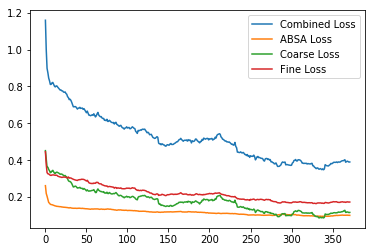

In [0]:
plt.plot(running_mean(train_loss_trace, 25), label='Combined Loss')
plt.plot(running_mean(train_head_loss_trace['ABSA'], 25), label='ABSA Loss')
plt.plot(running_mean(train_head_loss_trace['Entity'], 25), label='Coarse Loss')
plt.plot(running_mean(train_head_loss_trace['Entity_Fine'], 25), label='Fine Loss')
plt.legend()
plt.show()

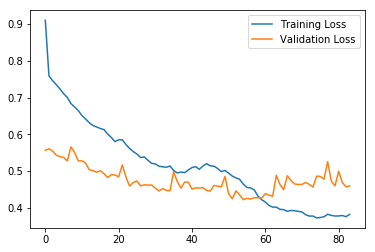

In [0]:
if args.evaluate_during_training:
    plot_train_val_trace(train_loss_trace, eval_loss_trace)

## Save Model

In [0]:
logger.info("Saving trained model to %s", args.output_dir)
tokenizer.save_pretrained(args.output_dir)
torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))
torch.save(model.state_dict(), os.path.join(args.output_dir, 'model.pt'))

09/02/2019 15:08:25 - INFO - __main__ -   Saving trained model to /content/gdrive/My Drive/TUM/Guided Research/output/Current/


## Testing

In [0]:
test_dataset = load_and_cache_examples(args, tokenizer, 'test')
test_loss, test_loss_trace, results = evaluate(args, model, tokenizer, test_dataset, prefix='Test set')

10/12/2019 21:21:30 - INFO - __main__ -   Creating features from dataset file at /content/gdrive/My Drive/TUM/Guided Research/data/
10/12/2019 21:21:30 - INFO - __main__ -   Writing example 0 of 433
10/12/2019 21:21:30 - INFO - __main__ -   *** Example ***
10/12/2019 21:21:30 - INFO - __main__ -   guid: test-0
10/12/2019 21:21:30 - INFO - __main__ -   tokens: ▁The ▁main ▁reason ▁real ▁organic ▁eggs ▁are ▁brown ▁is ▁that ▁most ▁the ▁heir loom ▁chicken ▁breed s ▁that ▁for age ▁well ▁lay ▁brown ▁eggs . <sep> <cls>
10/12/2019 21:21:30 - INFO - __main__ -   input_ids: 5 5 5 5 5 32 587 994 525 5881 6077 41 3442 27 29 127 18 9280 15127 5746 6835 23 29 28 981 143 2888 3442 6077 9 4 3
10/12/2019 21:21:30 - INFO - __main__ -   input_mask: 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
10/12/2019 21:21:30 - INFO - __main__ -   segment_ids: 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
10/12/2019 21:21:30 - INFO - __main__ -   label-ABSA: 0 0 0 0 0 0 0 0 0 0 0 0 

10/12/2019 21:21:33 - INFO - __main__ -   evaluation average loss = 0.47465954401663374


## Result Visualization

In [0]:
def barplot_classification_report(cr):
    f1s = []
    index = 0
    for i,key in enumerate(cr.keys()):
        if (key == 'accuracy'):
            f1s.append(cr.get(key))
            index = i
        else:
            f1s.append(cr.get(key).get('f1-score'))

    labels = list(cr.keys())
    labels[index] = 'micro avg'
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(12,5)})
    sns.barplot(labels, f1s, palette='deep')
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('F1-Score')
    plt.title('Joint Aspect-Sentiment classification performance')

In [0]:
def get_cr_reports(results, threshold, isPlot=False, shouldPrint=False):
    for head in headConfig:
        if isPlot:
            plot_classification_report(classification_report(results[head]['actual'], results[head]['preds'] > threshold, target_names=head_classes[head]), title=head+' Report', shouldPrint=shouldPrint)
        else:
            print(classification_report(results[head]['actual'], results[head]['preds'] > threshold, target_names=head_classes[head]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


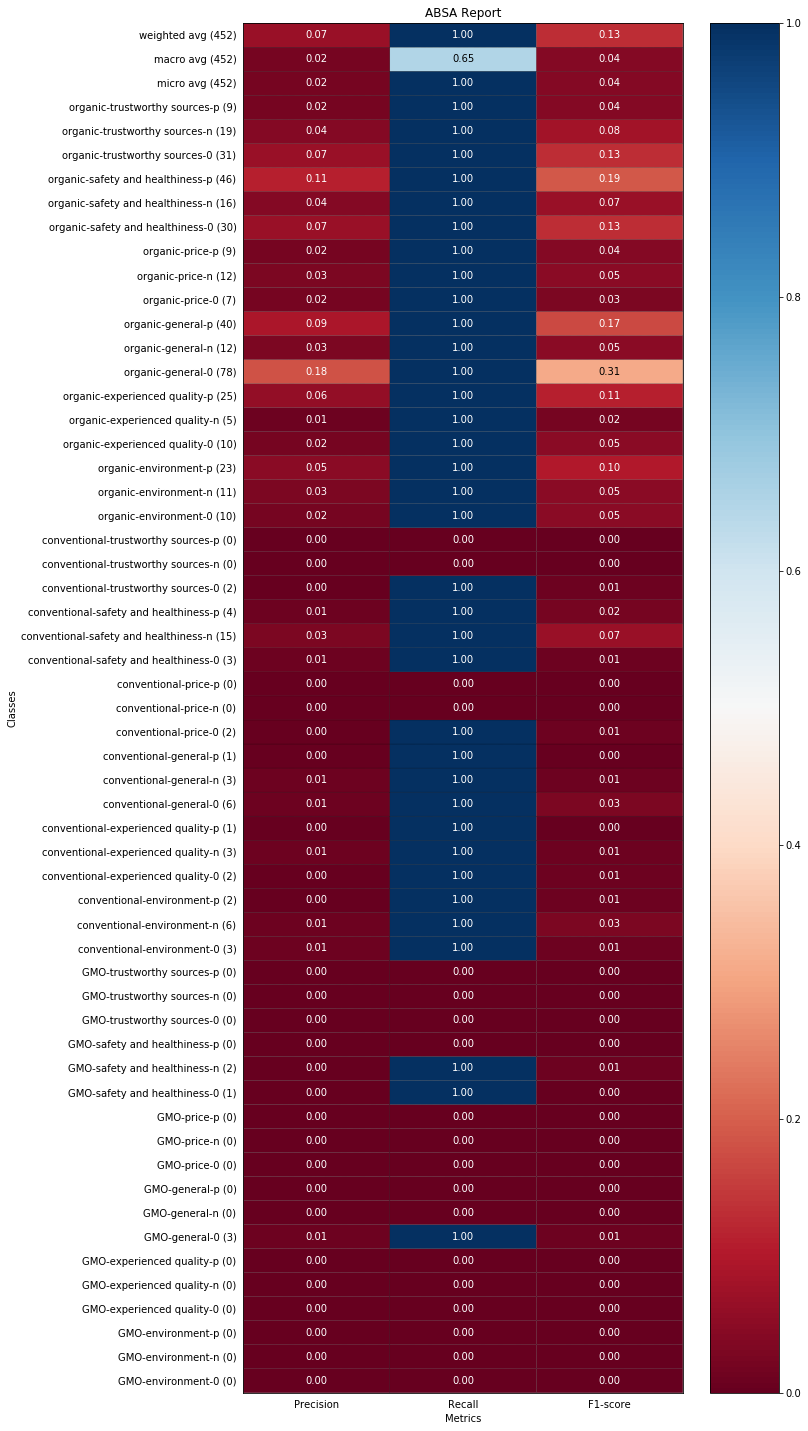

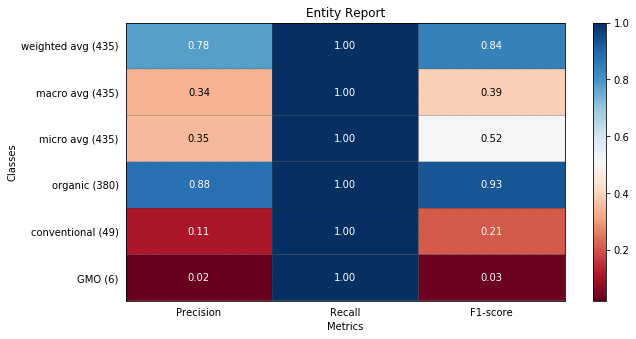

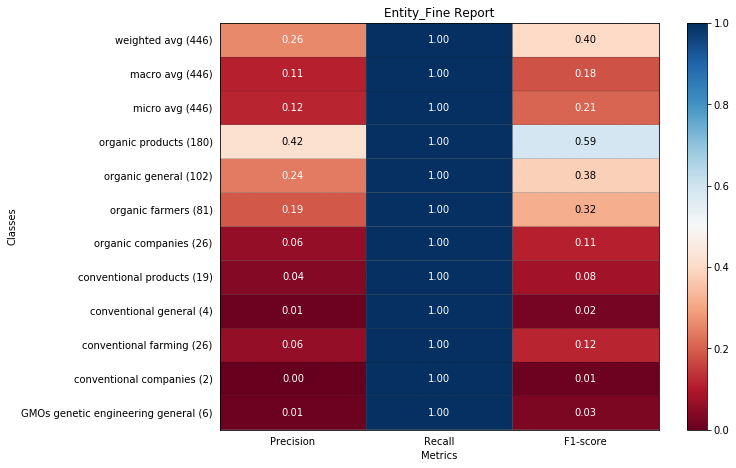

In [0]:
get_cr_reports(results, 0.1, isPlot=True, shouldPrint=False)

In [0]:
# FOR PRINTING PLOT OF CLASSIFICATION REPORT

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', shouldPrint=False):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    if (len(lines) > 100):
        return;

    plotMat = []
    support = []
    class_names = []
    report_data = []
    for line in lines[2 : (len(lines) - 2)]:
        t = re.split(r'\s{2,}', line.strip())
        if len(t) < 2:
            continue
        
        row = {}
        class_names.append(t[0])
        row['class'] = t[0]
        v = [float(x) for x in t[1: len(t) - 1]]
        row['precision'] = v[0]
        row['recall'] = v[1]
        row['f1_score'] = v[2]
        support.append(int(t[-1]))
        row['support'] = int(t[-1])
        
        #print(v)
        plotMat.append(v)
        report_data.append(row)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))
    if shouldPrint:
        pd.DataFrame.from_dict(report_data).to_csv(os.path.join(args.output_dir, title+'.csv'), index = False)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [0]:
cr = classification_report(labels,preds, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Joint Aspect-Sentiment classification performance')

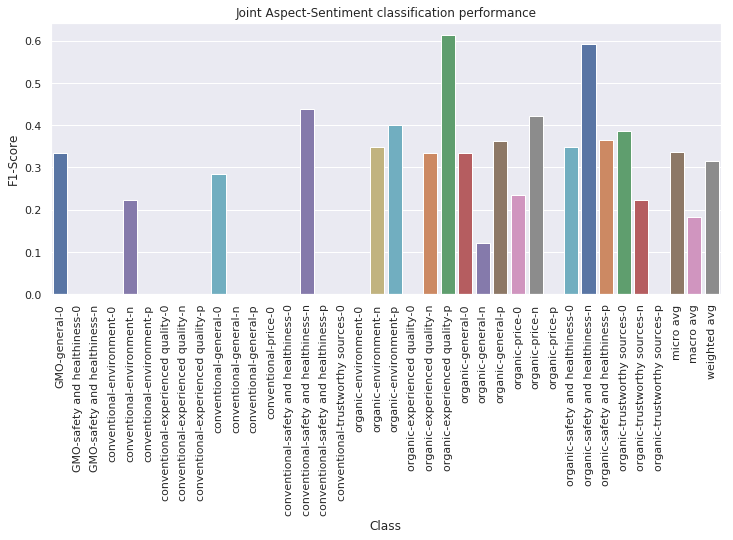

In [0]:
f1s = []
index = 0
for i,key in enumerate(cr.keys()):
    if (key == 'accuracy'):
        f1s.append(cr.get(key))
        index = i
    else:
        f1s.append(cr.get(key).get('f1-score'))

labels = list(cr.keys())
labels[index] = 'micro avg'
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(labels, f1s, palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Joint Aspect-Sentiment classification performance')